In [1]:
%matplotlib inline
from cct.core2.dataclasses import Exposure, Header, Curve
from cct.core2.algorithms.radavg import fastradavg, maskforannulus, maskforsectors, fastazimavg
from cct.core2.algorithms.readcbf import readcbf
from cct.core2.algorithms.centering.momentofinertia import _momentofinertia
import numpy as np
import scipy.optimize
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.colors
import os

In [2]:
fsn = 201
datafilename = f'../test/images_local/tst/tst_{fsn:05d}.cbf'
headerfilename = f'../test/param/tst_{fsn:05d}.pickle'
header = Header(filename = headerfilename)
maskname = os.path.split(header.maskname)[-1]
for folder, subdirs, files in os.walk('../test/mask'):
    print(folder, subdirs, files)
    if maskname in files:
        mask = scipy.io.loadmat(os.path.join(folder, maskname))
        mask = mask[[k for k in mask.keys() if not k.startswith('_')][0]]
        break
else:
    raise ValueError(f'Cannot find mask {maskname}')
data = readcbf(datafilename)
exposure = Exposure(data, header, data**0.5, mask)
print(header.title)

../test/mask ['Short', 'WAXS', 'Long'] ['mask.mat']
../test/mask/Short [] ['mask_short_20200505.mat', 'mask_short_20200817.mat', 'mask_short_20200106.mat']
../test/mask/WAXS [] []
../test/mask/Long [] ['mask_verylong_20190605_samples.mat', 'mask_long_20200615_samples.mat', 'mask_verylong_20190605.mat', 'mask_long_20200723.mat', 'mask_verylong_20190110.mat', 'mask_long_20200109.mat', 'mask_long_20200205.mat', 'mask_long_20200615.mat', 'mask_long_20200615_AnnaPetroczy.mat', 'mask_long_20200507.mat', 'mask_verylong_20200720.mat', 'mask_long_20200723_samples.mat']
AgBeh_SBA15_capillary


<ipython-input-2-2982e610bd24>:15: RuntimeWarning: invalid value encountered in sqrt
  exposure = Exposure(data, header, data**0.5, mask)


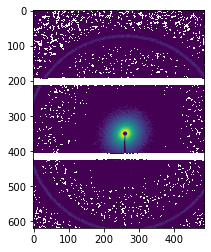

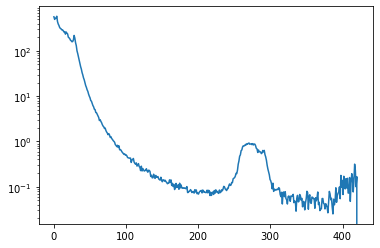

In [3]:
plt.imshow(exposure.intensity, norm = matplotlib.colors.LogNorm())
plt.figure()
rad = exposure.radial_average()
plt.semilogy(rad.pixel, rad.intensity)

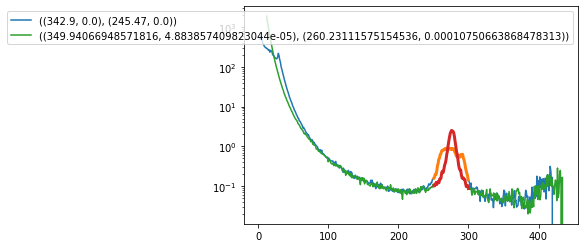

In [7]:
def lorentzian(x, hwhm, position, amplitude, offset):
    return hwhm**2/(hwhm**2+(x - position)**2)* amplitude + offset

def lorentziantargetfunc(peakparams, x, y):
    return y - lorentzian(x, peakparams[0], peakparams[1], peakparams[2], peakparams[3])

def powerlawtargetfunc(params, x, y):
    return y - params[0] * x**params[1]

def peakheight(beampos, matrix, mask, rmin, rmax):
    pixel, intensity, area = fastradavg(matrix, mask, beampos[0], beampos[1], rmin, rmax, 20)
    result = scipy.optimize.least_squares(
        lorentziantargetfunc,
        [(rmax-rmin)*0.5,
         0.5*(rmax+rmin),
         intensity.max()-intensity.min(),
         intensity.min()
         ],
        bounds=([0, rmin, 0, -np.inf],[10*(rmax-rmin), rmax, np.inf, np.inf]),
        args=(pixel, intensity),
    )
    if not result.success:
        return np.nan
    return -(result.x[2] + result.x[3])

def peakwidth(beampos, matrix, mask, rmin, rmax):
    pixel, intensity, area = fastradavg(matrix, mask, beampos[0], beampos[1], rmin, rmax, 20)
    result = scipy.optimize.least_squares(
        lorentziantargetfunc,
        [(rmax-rmin)*0.5,
         0.5*(rmax+rmin),
         intensity.max()-intensity.min(),
         intensity.min()
         ],
        bounds=([0, rmin, 0, -np.inf],[10*(rmax-rmin), rmax, np.inf, np.inf]),
        args=(pixel, intensity),
    )
    if not result.success:
        return np.nan
#    print(beampos, result.x[0])

    return result.x[0]

def slices(beampos, matrix, mask, rmin, rmax):
    N=int(rmax-rmin)
    pixels = np.empty((N, 4))
    intensities = np.empty((N, 4))
    areas = np.empty((N, 4))
    for i in range(4):
        msk = maskforsectors(mask, beampos[0], beampos[1], np.pi*0.25 + i * np.pi*0.5, np.pi*0.25, symmetric=False)
        pixels[:, i], intensities[:,i], areas[:, i] = fastradavg(matrix, msk, beampos[0], beampos[1], rmin, rmax, N)
    valid = areas.prod(axis=1) > 0
    return ((intensities[valid, 0] - intensities[valid, 2])**2 + (intensities[valid, 1] - intensities[valid, 3])**2).mean()

def powerlaw(beampos, matrix, mask, rmin, rmax):
    pixel, intensity, area = fastradavg(matrix, mask, beampos[0], beampos[1], rmin, rmax, 20)
    valid = np.logical_and(np.isfinite(pixel), np.isfinite(intensity))
    pixel = pixel[valid]
    intensity = intensity[valid]
    result = scipy.optimize.least_squares(
        powerlawtargetfunc,
        [1, -4],
        bounds=([0, -6],[np.inf, 0]),
        args=(pixel, intensity),
    )
    if not result.success:
        return np.nan
    return result.cost

def momentofinertia(beampos, matrix, mask, rmin, rmax):
    return -_momentofinertia(matrix, mask, beampos[0], beampos[1], rmin, rmax)

def azimuthal(beampos, matrix, mask, rmin, rmax):
    msk = maskforannulus(mask, beampos[0], beampos[1], rmin, rmax)
    phi, intensity, area = fastazimavg(matrix, msk, beampos[0], beampos[1], int((rmin+rmax)*np.pi/2 ))
    return intensity[area>0].std()

def azimuthal_fold(beampos, matrix, mask, rmin, rmax):
    msk = maskforannulus(mask, beampos[0], beampos[1], rmin, rmax)
    phi, intensity, area = fastazimavg(matrix, msk, beampos[0], beampos[1], int((rmin+rmax)*np.pi/4)*2)
    diff = intensity[:len(intensity)//2] - intensity[len(intensity)//2:]
    return diff[np.isfinite(diff)].mean()

def findbeam_crude(targetfunc, exposure, rmin, rmax, d=30, N=10):
    bestvalue = np.inf
    bestposition = None
    values = np.empty((N,N), dtype=np.double)
    for irow, beamrow in enumerate(np.linspace(exposure.header.beamposrow[0]-d, exposure.header.beamposrow[0]+d, N)):
        for icol, beamcol in enumerate(np.linspace(exposure.header.beamposcol[0]-d, exposure.header.beamposcol[0]+d, N)):
            value = targetfunc((beamrow, beamcol), exposure.intensity, exposure.mask, rmin, rmax)
            if value < bestvalue:
                bestvalue = value
                bestposition = (beamrow, beamcol)
            values[irow, icol] = value
    return bestposition, values

def findbeam(algorithm, exposure, rmin, rmax, dcrude=30, Ncrude=10):
    if dcrude > 0 and Ncrude > 0:
        crudeposition,values = findbeam_crude(algorithm, exposure, rmin, rmax, dcrude, Ncrude)
        plt.figure()
        plt.imshow(values, cmap='coolwarm')
    else:
        crudeposition = (exposure.header.beamposrow[0], exposure.header.beamposcol[0])
    result = scipy.optimize.minimize(
        algorithm,
        crudeposition,
        args = (exposure.intensity, exposure.mask, rmin, rmax),
        method = 'L-BFGS-B',
        options={'ftol' : 1e7*np.finfo(float).eps, 'eps': 0.01},
    )

    ftol = 1e7 * np.finfo(float).eps  # L-BFGS-B default factr value is 1e7
    covar = max(1, np.abs(result.fun)) * ftol * result.hess_inv.todense()
    return (result.x[0], covar[0,0]**0.5), (result.x[1], covar[1,1]**0.5)

rmin = 250
rmax = 300

beamx, beamy = findbeam(peakheight, exposure, rmin, rmax, 0, 0)
#beamx, beamy = findbeam(azimuthal_fold, exposure, rmin, rmax)

def plotwithbeampos(exposure, beamposrow, beamposcol):
    origbeamrow = exposure.header.beamposrow
    origbeamcol = exposure.header.beamposcol
    if beamposrow is None:
        beamposrow = origbeamrow
    if beamposcol is None:
        beamposcol = origbeamcol
    exposure.header.beamposrow = beamposrow
    exposure.header.beamposcol = beamposcol
    rad = exposure.radial_average()
    line = plt.semilogy(rad.pixel, rad.intensity, label = f'{beamposrow, beamposcol}')[0]
    rad1=rad.trim(rmin, rmax, bypixel=True)
    plt.semilogy(rad1.pixel, rad1.intensity, lw = 3,) #color=line.get_color(), lw=3)
    exposure.header.beamposrow = origbeamrow
    exposure.header.beamposcol = origbeamcol
plt.figure()
plotwithbeampos(exposure, None, None)
plotwithbeampos(exposure, beamx, beamy)
plt.legend(loc='best')
